In [7]:
import os
import sys
import numpy as np
sys.path.append('/home/joao/lib/dredge/dredge-python/')
from pathlib import Path
from labdata.schema import *
from dredge.dredge_ap import register

os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [8]:
Dataset() & 'subject_name = "JC131"' & 'dataset_name = "freely_moving"'

subject_name unique mouse id,session_name session identifier,dataset_name,dataset_type,setup_name setup name,notetaker username,note_datetime
JC131,20231025_193343,freely_moving,None,None,None,None
JC131,20231025_194303,freely_moving,None,None,None,None


In [9]:
SAVEPATH = Path(r'/home/mmelin/chronic_manuscript_figures')

SUBJECTS = ['JC131',]
PROBENUM = [0,]
SESSIONS = ['20231025_194303',]
labels = []

/home/mmelin/data/JC131/20231025_194303/ephys_g2/ephys_g2_imec0
Spike detection already ran for JC131 20231025_194303


Cross correlation:   0%|          | 0/2 [00:00<?, ?it/s]

/home/joao/lib/dredge/dredge-python/dredge/dredgelib.py:707: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  Ex = conv1d(x[:, None, :], weights, padding=padding)


Weights:   0%|          | 0/2 [00:00<?, ?it/s]

Solve:   0%|          | 0/1 [00:00<?, ?it/s]

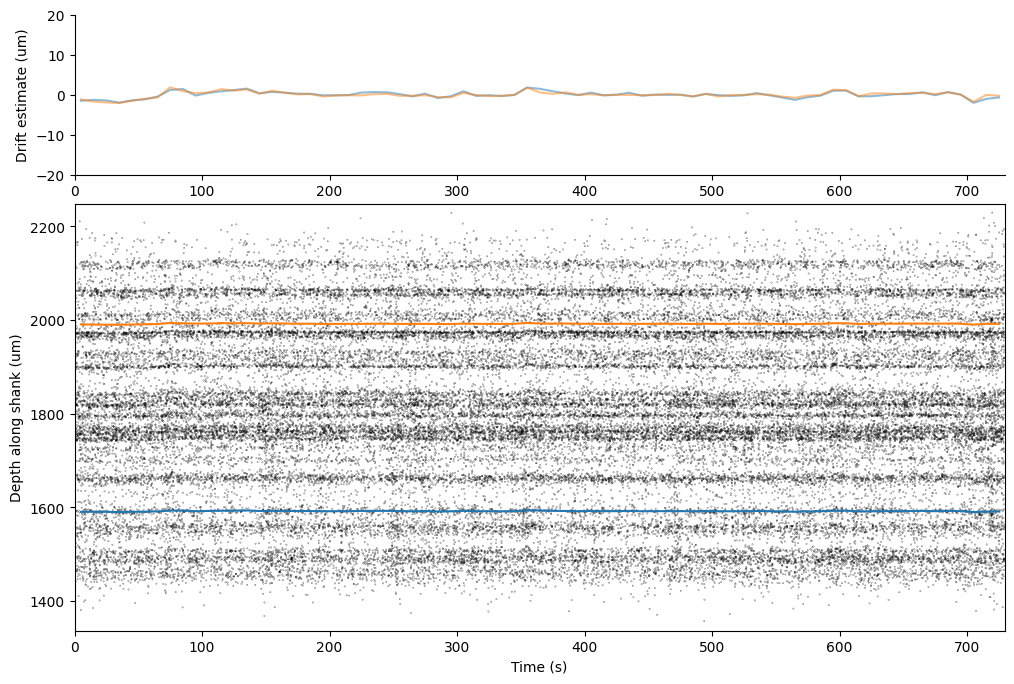

In [14]:
# run spike detection and localization, and save results
from spks.viz import plot_drift_raster
import matplotlib.pyplot as plt

from matplotlib import gridspec
spec = gridspec.GridSpec(ncols=1, nrows=2,
                         wspace=.2,
                         hspace=.1,height_ratios=[.75,2])

from utils import extract_spikes
ests = []
for p,s,d in zip(PROBENUM,SUBJECTS,SESSIONS):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(spec[1])
    peaks, peak_locations = extract_spikes(s,d,p)
    t_seconds = peaks['sample_index'] / 30000
    amps = np.abs(peaks['amplitude'])
    depth_um = peak_locations['y']

    valid_spikes = depth_um < 3500
    t_seconds = t_seconds[valid_spikes]
    depth_um = depth_um[valid_spikes]
    amps = amps[valid_spikes]

    motion_est, _ = register(amps, depth_um, t_seconds, bin_s=5)
    ests.append(motion_est)
    #TODO: NEED TO SEPARATE OUT THE UNITS BY SHANK
    plot_drift_raster(t_seconds, depth_um, amps, n_spikes_to_plot=50000, clim=(0,100), cmap='gray_r',rasterized=True)
    plt.plot(motion_est.time_bin_centers_s, motion_est.displacement.T + motion_est.spatial_bin_centers_um)
    plt.ylabel('Depth along shank (um)')
    plt.xlabel('Time (s)')
   
    fig.add_subplot(spec[0], sharex=ax)
    plt.plot(motion_est.time_bin_centers_s, motion_est.displacement.T, alpha=.5)
    plt.ylim(-20,20)
    plt.ylabel('Drift estimate (um)')
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.show()
    #plt.savefig(SAVEPATH / f'{s}_{d.replace("/","-")}_drift.pdf', dpi=300, format='pdf', bbox_inches='tight')
    

In [12]:
# Quantify DREDGE traces
all_var = []
for isess, motion_est in enumerate(ests):
    sess_var = []
    motion = motion_est.displacement
    #variance = np.var(motion,axis=1)
    #motion = np.abs(np.diff(motion, axis=1))
    variance = np.std(motion,axis=1)
    #variance = np.mean(np.abs(np.diff(motion, axis=1)), axis=1)
    all_var.append(variance)
all_var = np.stack(all_var)
print(all_var.shape)

(1, 2)


ValueError: x and y must be the same size

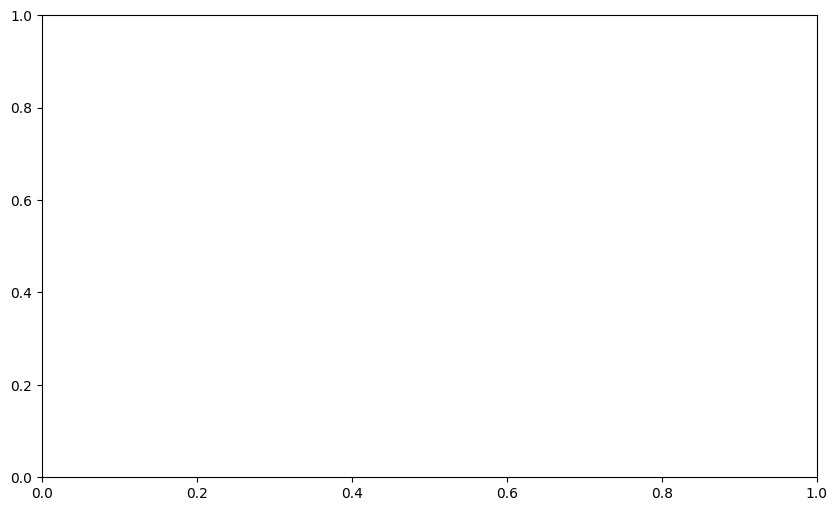

In [13]:
xvals = [0, .5, 1.5, 2, 3, 3.5]
#error = [np.std(i) / np.sqrt(len(i)) for i in all_var] # SEM
import scipy.stats as st
ci_95 = [st.t.interval(.95, df=len(d)-1, loc=np.mean(d), scale=st.sem(d))  for d in all_var] # create 95% confidence interval 
#ci_95 = [st.chi2.interval(.95, df=len(d)-1, loc=np.median(d), scale=st.sem(d))  for d in all_var] # create 95% confidence interval 
#ci_95 = np.sqrt(np.array(ci_95))
#ci_95 = [st.chi2.interval(.95, df=len(d)-1, loc=np.median(d), scale=1)  for d in all_var] # create 95% confidence interval 
#ci_95 = [st.chi.interval(.95, df=len(d)-1, loc=np.mean(d) )  for d in all_var] # create 95% confidence interval 
fig = plt.figure(figsize=(10,6))

#plt.errorbar(xvals, np.mean(all_var, axis=1), yerr=ci_95, markersize=5, capsize=8, marker='D', linestyle='none', color='black')
plt.scatter(xvals, np.mean(all_var, axis=1), s=20, marker='D', color='black')
#plt.scatter(xvals, np.median(all_var, axis=1), s=20, marker='D', color='black')
for i,e in enumerate(ci_95):
    plt.plot(xvals[i]*np.array([1,1]),e,'_-',lw=1,color='black')
for i,x in enumerate(xvals):
    plt.scatter([x]*len(all_var[i]), all_var[i], s=4)

#plt.gca().set_xticklabels(labels)
plt.ylabel('Standard deviation of motion estimate (μm)')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xticks(xvals, labels, rotation=-40)
#plt.ylim(0,4)
plt.plot()
plt.show()
plt.savefig(SAVEPATH / 'quantify_dredge_traces.pdf', format='pdf', dpi=500, bbox_inches='tight')